In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sym
import numpy as np
import scipy as sp

sns.set()
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
def sim(runway_dist=10_000, angle=5, init_vel=200/3.6, acc_dev=2):
    cosx = np.cos(angle * (np.pi / 180))
    sinx = np.sin(angle * (np.pi / 180))

    def state(d):
        # Return the real state as a function d
        return np.array([d * cosx, 0, d * sinx])  # [x,y,z]
    
    def ra(d):
        return np.sqrt((1000 - d*np.cos(5*(np.pi/180)))**2 + (500)**2 + (d*np.sin(5*(np.pi/180)))**2)

    def rb(d):
        return np.sqrt((-500 - d*np.cos(5*(np.pi/180)))**2 + (500)**2 + (d*np.sin(5*(np.pi/180)))**2)
        
    def ry(d):
        return d*np.sin(5*(np.pi/180))

    # d is the radial distance (of the plane) away from the origin
    d = runway_dist / cosx  # Starting d
    v = init_vel
    
    while d > 0:
        yield (
            d,
            state(d), 
            v,  # Multiply v by 3.6 to get km/h
            ra(d) + np.random.randn() * np.sqrt(20**2 / 2),
            rb(d) + np.random.randn() * np.sqrt(20**2 / 2),
            ry(d) + np.random.randn() * 5,
        )
        
        v += np.random.randn() * acc_dev
        d -= v  # d -= vel*dt, where dt = 1

In [3]:
ys = list(sim())

In [4]:
ds = [y[0] for y in ys]
ss = [y[1] for y in ys]
vs = [y[2] for y in ys]
ras = [y[3] for y in ys]
rbs = [y[4] for y in ys]
rys = [y[5] for y in ys]

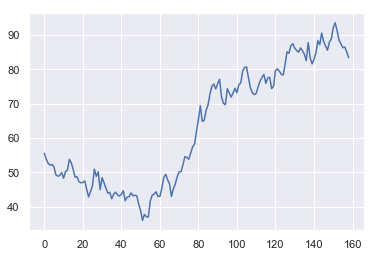

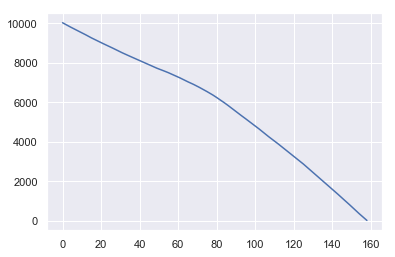

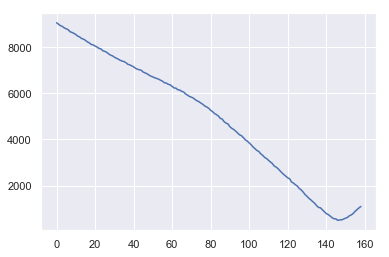

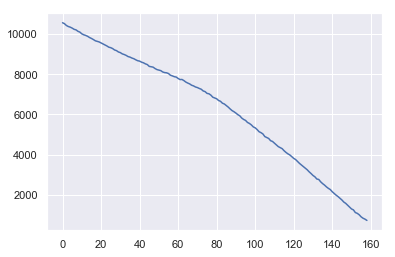

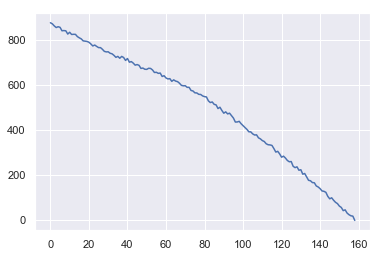

In [5]:
plt.plot(vs)
plt.show()
plt.plot(ds)
plt.show()
plt.plot(ras)
plt.show()
plt.plot(rbs)
plt.show()
plt.plot(rys)
plt.show()

# Defining the problem

We can define the state to be 
$$
    \begin{bmatrix}
        d \\ v
    \end{bmatrix}
$$
Where $d$ is the radial distance away from the origin, and $v$ is the velocity in the same direction.

We have 5 measurements that we take but due to the symmetry about the y-axis we can reduce this down to 3 measurements in the Kalman Filter

Let's define the average of the two measurements at $x=1000$ to be $r_a$, and the the average of the two measurements at $x=-500$ to be $r_b$, we do this because it allows us to effectively half the variance for each of these measurements (good!). The height measurement we can define as $r_h$. 

More concretely
$$
    r_a[n] = \frac{1}{2} \Big( r_{(1000,500)}[n] + r_{(1000,-500)}[n] \Big)
$$
and
$$
    r_b[n] = \frac{1}{2} \Big( r_{(-500,500)}[n] + r_{(-500,-500)}[n] \Big)
$$
Where $n$ is the $n^{th}$ timestep since the start of measurements (ie when the plane was 10km away along the ground)



<br>

# Update and prediction portion

## Update matrix
We know that from the problem the update matrix will be:

$$
    A = \begin{bmatrix}
        1 & \Delta t \\
        0 & 1
    \end{bmatrix}
$$

And the gain update matrix

$$
    B = \begin{bmatrix}
        0 \\
        1
    \end{bmatrix}
$$

And with the update covariance: 

$$
    Q_u = \begin{bmatrix}
        0 & 0 \\
        0 & 4
    \end{bmatrix}
$$

This basically says that there is no variance on the position (directly) and a variance on velocity of $2^2 = 4 \frac{m}{s^2}$ 

<br>

# Sensitivity matrix
## Finding the H matrix
We can also define the $H$ matrix using simple trigonometry. 

First we find what the radial distance from each sensor (also remember we use the 'fake' $r_a$ and $r_b$ here):

$$
    \begin{align*}
        r_a(d) &= \sqrt{ (1000 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 } \\
        r_b(d) &= \sqrt{ (-500 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 } \\
        r_h(d) &= d\ sin(5°) \\
    \end{align*}
$$

So we get the following $H$:

$$
    H = \begin{bmatrix}
        \sqrt{ (1000 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 }  & 0 \\
        \sqrt{ (-500 - d\ cos(5°))^2 + (500)^2 + (d\ sin(5°))^2 }  & 0 \\
        d\ sin(5°)  & 0 \\
    \end{bmatrix}
$$


Where we know from the question that the measurement covariance will be:

$$
    Q_w = \begin{bmatrix}
        \frac{1}{2}(20^2) & 0 & 0 \\
        0 & \frac{1}{2}(20^2) & 0 \\        
        0 & 0 & 5^2 \\
    \end{bmatrix} = \begin{bmatrix}
        200 & 0 & 0 \\
        0 & 200 & 0 \\        
        0 & 0 & 25 \\
    \end{bmatrix}
$$

The reason for the $\frac{1}{2}$ (as mentioned above) is due to having two symmetric measurements which are then averaged, effectively creating a new single measurement with half the variance of the two original measurements.


# Setup

Similarily to the lecture slides we will have:

The state vector:
$$s(n) = \begin{bmatrix} d_n \\ v_n \end{bmatrix}$$


The update equation can be written as:
$$
    \begin{bmatrix}
        d_n \\ v_n
    \end{bmatrix} = \begin{bmatrix}
        1 & -1 \\
        0 & 1
    \end{bmatrix} \begin{bmatrix}
        d_{n-1} \\ v_{n-1}
    \end{bmatrix} + \begin{bmatrix}
        0 \\ u_n
    \end{bmatrix}
$$

The initial state:
$$
    s(0,0) = \begin{bmatrix}
        d_0 \\ v_0
    \end{bmatrix} = \begin{bmatrix}
        10000\frac{1}{cos(5°)} \\ 200000
    \end{bmatrix}
$$

The initial uncertainty is zero (assumption from the question):
$$M(0,0) = 0$$

In [12]:
# Setup stuff

dt = 1  # Δt = 1 second

A = np.array([[1, -dt], [0, 1]])
B = np.array([[1],[0]])

Qu = np.array([[0, 0], [0, 4]])
Qw = np.array([[200, 0, 0], [0, 200, 0], [0, 0, 25]])

def H(d):
    cos5 = np.cos(5 * (np.pi/180))
    sin5 = np.sin(5 * (np.pi/180))
    xp = d * cos5
    zp = d * sin5  # Note this is the z component from the original question not y
    rp = np.array([xp, 0, zp]).T
    R1p = np.array([xp - 1000, 500, zp])
    R2p = np.array([xp + 500, 500, zp])
    return np.array([
        [(R1p @ rp) / (np.linalg.norm(R1p) * np.linalg.norm(rp)), 0],
        [(R2p @ rp) / (np.linalg.norm(R2p) * np.linalg.norm(rp)), 0],
        [sin5, 0],
    ]), np.linalg.norm(R1p), np.linalg.norm(R2p), zp



In [22]:
# Initialize all the things to be used

smm = np.array([10_000 / (np.cos(5 * (np.pi/180))), 200/3.6])  # velocity in m/s not km/h
Mmm = np.zeros((2,2)) 


# ds, ss, vs, ras, rbs, rys
Nt = len(ds)
zs = np.zeros((Nt, 3)) 
zs[:, 0] = ras
zs[:, 1] = rbs
zs[:, 2] = rys
Ks = []
d_preds = []
v_preds = []

# main KF loop
for k, z in enumerate(zs):
    skm = A @ smm  # prediction
    d = skm[0]
#     Mkm = A @ Mmm @ A.T + B @ B.T @ Qu  # covariance of prediction
    Mkm = A @ Mmm @ A.T + Qu  # covariance of prediction
    h, R1, R2, zp = H(d)
    K = Mkm @ h.T @ np.linalg.inv(h @ Mkm @ h.T + Qw)  # Kalman gain matrix
    skk = skm + K @ (z - np.array([R1, R2, zp]))   # correction    
    Mmm = (np.eye(2) - K @ h) @ Mkm   # update the covariance
    smm = skk   # ready for new round
    Ks.append(K)
    d_preds.append(skk[0])
    v_preds.append(skk[1])

Ks = np.array(Ks)

(159, 2, 3)


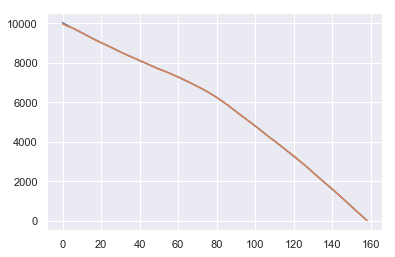

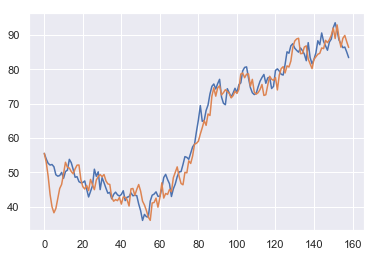

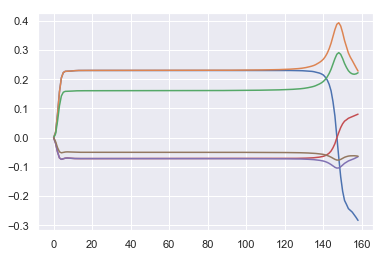

In [25]:
print(Ks.shape)
plt.plot(ds)
plt.plot(d_preds)
plt.show()
plt.plot(vs)
plt.plot(v_preds)
plt.show()
for i in range(Ks.shape[1]):
    for j in range(Ks.shape[2]):
        plt.plot(Ks[:,i,j])
plt.show()

In [ ]:
Ks[100]